Processing: 01 - lol easy.jpg


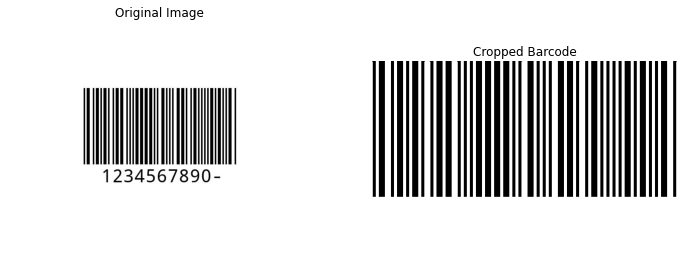

Processing: 02 - still easy.jpg


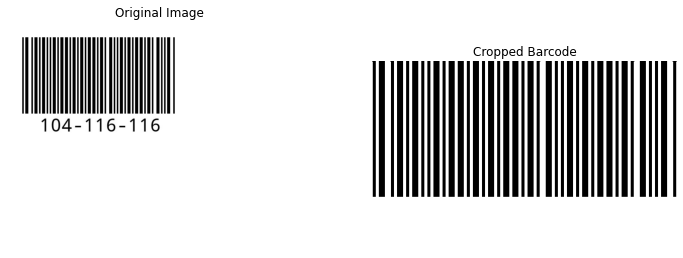

Processing: 03 - eda ya3am ew3a soba3ak mathazarsh.jpg


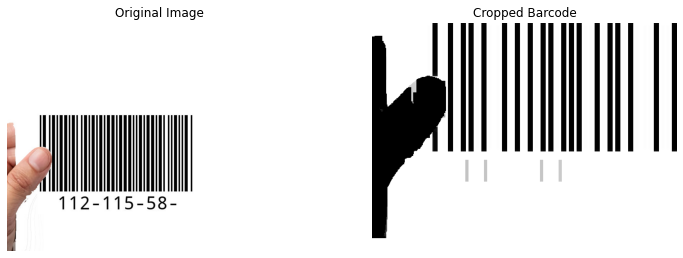

Processing: 04 - fen el nadara.jpg


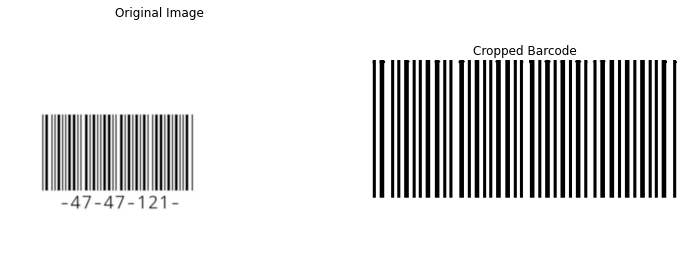

Processing: 05 - meen taffa el nour!!!.jpg


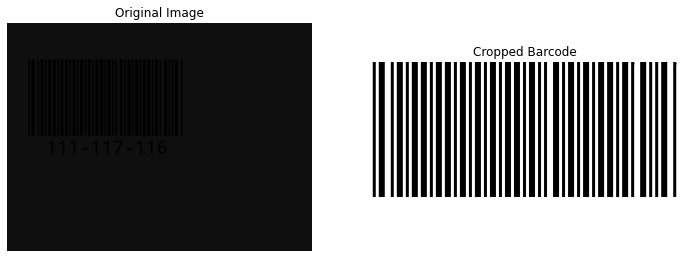

Processing: 06 - meen fata7 el nour 333eenaaayy.jpg


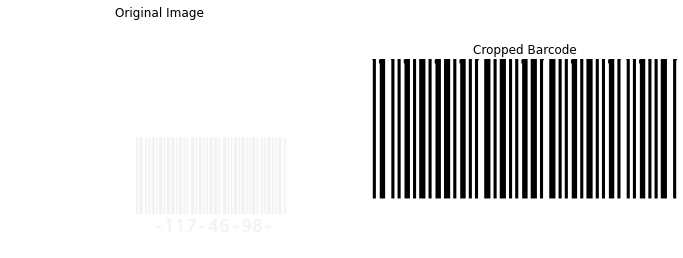

Processing: 07 - mal7 w felfel.jpg


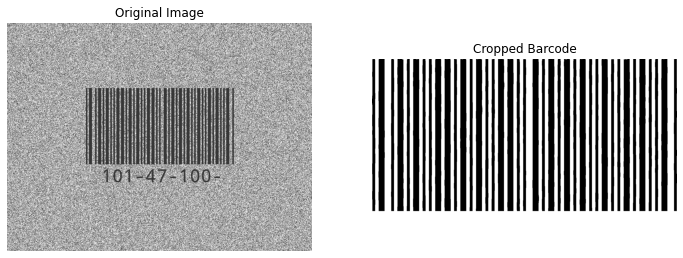

Processing: 08 - compresso espresso.jpg


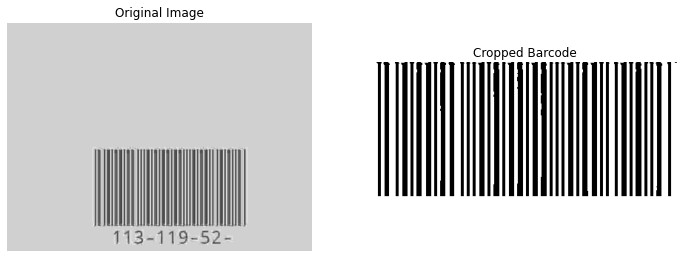

Processing: 09 - e3del el soora ya3ammm.jpg


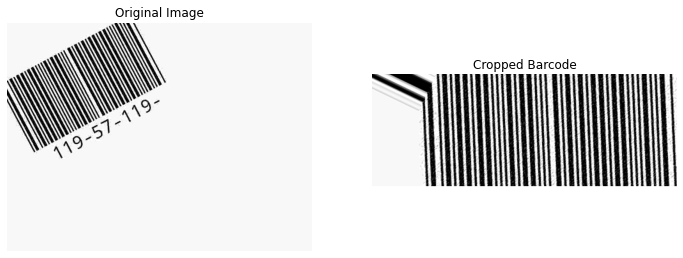

Processing: 10 - wen el kontraastttt.jpg


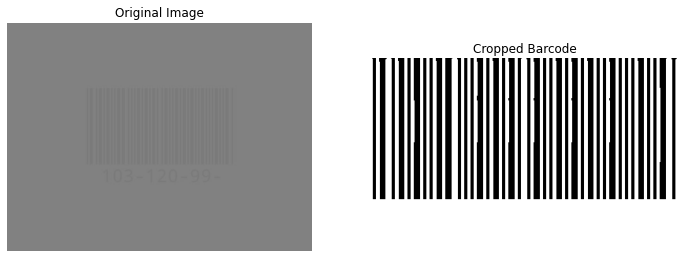

Processing: 11 - bayza 5ales di bsara7a.jpg


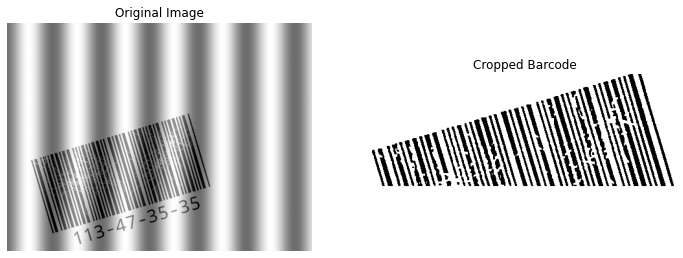

In [10]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

def remove_hand(image_path):
    """
    Removes the hand from the image using skin color segmentation.
    """
    img = cv.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image at path {image_path}")
        return None

    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    skin_mask = cv.inRange(hsv, lower_skin, upper_skin)
    _, skin_mask = cv.threshold(skin_mask, 127, 255, cv.THRESH_BINARY_INV)

    hand_removed = cv.bitwise_and(img, img, mask=skin_mask)
    hand_removed_gray = cv.cvtColor(hand_removed, cv.COLOR_BGR2GRAY)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 30))
    img_no_hand = cv.morphologyEx(hand_removed_gray, cv.MORPH_CLOSE, kernel)

    kernel_dilate = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
    img_no_hand = cv.dilate(img_no_hand, kernel_dilate, iterations=1)

    kernel_erode = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
    img_no_hand = cv.erode(img_no_hand, kernel_erode, iterations=1)

    return img_no_hand

def remove_numbers_from_bottom(img, margin=20):
    """
    Removes numbers or unwanted text at the bottom of the barcode by setting that area to white.
    """
    bottom_part = img[-margin:, :]
    _, thresholded_bottom = cv.threshold(bottom_part, 240, 255, cv.THRESH_BINARY_INV)
    img[-margin:, :] = cv.bitwise_or(img[-margin:, :], thresholded_bottom)
    img[-margin:, :] = 255
    return img

def crop_barcode(img):
    """
    Crops the barcode region from the image using contours.
    """
    if len(img.shape) == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    _, thresholded = cv.threshold(img, 128, 255, cv.THRESH_BINARY_INV)
    contours, _ = cv.findContours(thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours detected! Skipping this image.")
        return img

    x_min = min([cv.boundingRect(contour)[0] for contour in contours])
    x_max = max([cv.boundingRect(contour)[0] + cv.boundingRect(contour)[2] for contour in contours])
    largest_contour = max(contours, key=cv.contourArea)
    _, y, _, h = cv.boundingRect(largest_contour)

    cropped_img = img[y:y + h, x_min:x_max]
    cropped_img = remove_numbers_from_bottom(cropped_img)

    return cropped_img

def display_before_after(original_img, cropped_img, title_before="Original Image", title_after="Cropped Barcode"):
    """
    Displays the before and after images side by side using Matplotlib.
    """
    plt.figure(figsize=(12, 6))

    # Display the original image
    plt.subplot(1, 2, 1)
    if len(original_img.shape) == 2:  # Grayscale
        plt.imshow(original_img, cmap='gray')
    else:  # Color
        plt.imshow(cv.cvtColor(original_img, cv.COLOR_BGR2RGB))
    plt.title(title_before)
    plt.axis('off')

    # Display the cropped barcode image
    plt.subplot(1, 2, 2)
    if len(cropped_img.shape) == 2:  # Grayscale
        plt.imshow(cropped_img, cmap='gray')
    else:  # Color
        plt.imshow(cv.cvtColor(cropped_img, cv.COLOR_BGR2RGB))
    plt.title(title_after)
    plt.axis('off')

    plt.show()

def preprocess_image(image_path, special_image=False, straighten_and_clean=False, remove_hand_image=False):
    """
    Preprocesses the image based on specific conditions.
    """
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

    if remove_hand_image:
        img = remove_hand(image_path)
    elif straighten_and_clean:
        img = straighten_and_clean_9th_photo(img)
    elif special_image:
        kernel = np.ones((7, 1), np.float32) / 5
        img = cv.filter2D(img, -1, kernel)
        scale_factor = 4
        img = cv.resize(img, (img.shape[1] * scale_factor, img.shape[0] * scale_factor))
        _, img = cv.threshold(img, 128, 255, cv.THRESH_BINARY)
        kernel = np.zeros((13, 13), np.uint8)
        kernel[:, kernel.shape[1] // 2] = 1
        img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
        kernel = np.zeros((21, 21), np.uint8)
        kernel[:, kernel.shape[1] // 2] = 1
        img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
        kernel = np.ones((1, 5), np.uint8)
        img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
    else:
        img = cv.GaussianBlur(img, (5, 5), 0)
        img = cv.normalize(img, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)
        img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 15, 8)
        kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 1))
        img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
        kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 3))
        img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

    return img

def process_test_cases(image_folder, special_image_index, straighten_image_index, remove_hand_index):
    """
    Processes all images in the folder. Displays before and after images and saves only the cropped results.
    """
    files = [file_name for file_name in os.listdir(image_folder) if file_name.endswith(".jpg")]
    files.sort(key=lambda x: int(x.split(' ')[0]))
    output_folder = os.path.join(image_folder, "Processed_Output")
    os.makedirs(output_folder, exist_ok=True)

    for i, file_name in enumerate(files):
        print(f"Processing: {file_name}")
        image_path = os.path.join(image_folder, file_name)
        straighten_and_clean = (i + 1 == straighten_image_index)
        special_image = (i + 1 == special_image_index)
        remove_hand_image = (i + 1 == remove_hand_index)

        # Load original image
        original_img = cv.imread(image_path)
        cleaned_img = preprocess_image(image_path, special_image=special_image, straighten_and_clean=straighten_and_clean, remove_hand_image=remove_hand_image)
        cropped_img = crop_barcode(cleaned_img)

        # Save the cropped barcode image
        cropped_path = os.path.join(output_folder, f"Cropped_{file_name}")
        cv.imwrite(cropped_path, cropped_img)

        # Display before and after images
        display_before_after(original_img, cropped_img)

if __name__ == "__main__":
    image_folder = "/Users/mohamedwalid/Desktop/Semester 7/Computer vision/CV-main/Test Cases-20241123"
    special_image_index = 7
    straighten_image_index = 9
    remove_hand_index = 3
    process_test_cases(image_folder, special_image_index, straighten_image_index, remove_hand_index)
